# Differential Privacy Case Study

In [2]:
# Libraries
import numpy as np
from matplotlib import pyplot as plt
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "font.size": 14}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
import pymc3 as pm
import seaborn as sns
from functools import reduce
import theano.tensor as tt
from scipy.integrate import quad

import arviz as az
import pandas as pd
import subprocess # for calling leakiest

## Sklearn mutual info implementation
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest

## Scipy entropy/kl-divergence
from scipy.stats import entropy
from scipy.stats import norm

print("Running on PyMC3 v{}".format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


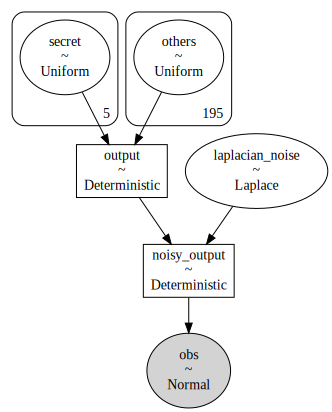

In [3]:
# Model: Adding up two numbers
def create_model(ϵ):
    with pm.Model() as model:
        N1 = 5
        N2 = 195
        s  = N1+N2
        secret = pm.Uniform("secret",lower=10,upper=200,shape=N1)
        others = pm.Uniform("others",lower=80,upper=90,shape=N2)        
        output = pm.Deterministic("output",(secret.sum()+others.sum())/s)

        Δ=200/s
        laplacian_noise = pm.Laplace("laplacian_noise",mu=0,b=Δ/ϵ)    
        noisy_output = pm.Deterministic("noisy_output", output+laplacian_noise)
        ## `obs` must be comment out depending on the experiment
        obs = pm.Normal("obs",mu=noisy_output, sigma=.1, observed=85)
    return model
    
pm.model_to_graphviz(create_model(1))

In [5]:
model=create_model(100)
trace=pm.sample(10000,cores=2,tune=5000,model=model,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [laplacian_noise, others, secret]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 38 seconds.


array([[<AxesSubplot:title={'center':'laplacian_noise'}>,
        <AxesSubplot:title={'center':'laplacian_noise'}>],
       [<AxesSubplot:title={'center':'secret'}>,
        <AxesSubplot:title={'center':'secret'}>],
       [<AxesSubplot:title={'center':'others'}>,
        <AxesSubplot:title={'center':'others'}>],
       [<AxesSubplot:title={'center':'output'}>,
        <AxesSubplot:title={'center':'output'}>],
       [<AxesSubplot:title={'center':'noisy_output'}>,
        <AxesSubplot:title={'center':'noisy_output'}>]], dtype=object)

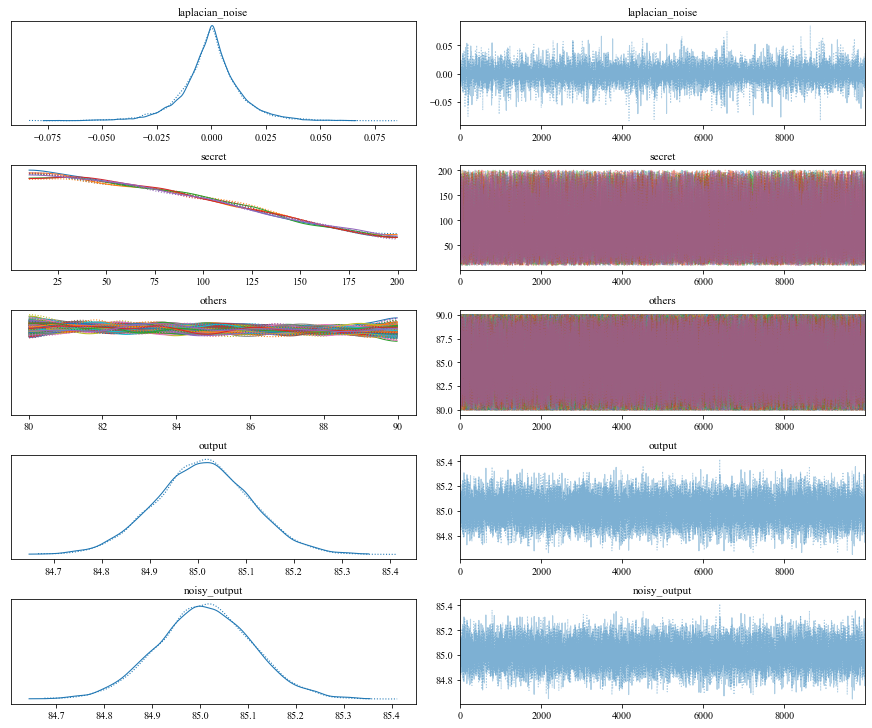

In [6]:
pm.plot_trace(trace)

In [11]:
## If you prefer, instead of running the inference, you can re-use pre-computed traces
TRACES_DIR='pymc3-traces-differential-privacy/'

### Without observation
trace_ϵ001=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.01.netcdf')
trace_ϵ01=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.1.netcdf')
trace_ϵ05=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.5.netcdf')
trace_ϵ07=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.7.netcdf')
trace_ϵ1=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ1.netcdf')
trace_ϵ2=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ2.netcdf')

### With observation
# trace_ϵ001=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.01_obs.netcdf')
# trace_ϵ01=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.1_obs.netcdf')
# trace_ϵ05=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.5_obs.netcdf')
# trace_ϵ07=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ0.7_obs.netcdf')
# trace_ϵ1=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ1_obs.netcdf')
# trace_ϵ2=az.from_netcdf(TRACES_DIR+'dp_10000_ϵ2_obs.netcdf')

### Probability queries

In [8]:
## NOTE: use traces with observation
bound=80
x=[0.01,0.1,0.5,0.7,1,2]
traces=[trace_ϵ001,trace_ϵ01,trace_ϵ05,trace_ϵ07,trace_ϵ1,trace_ϵ2]
y=[np.mean(trace.posterior['secret'][:,:,0]<bound) for trace in traces]
plt.xlabel('$\epsilon$')
plt.ylabel(r'$P(s_i<80 \; | \; o \approx 85)$')
plt.axhline(y=(bound-10)/190,color='black',linestyle='--',label='$P(s_i<80)$')
plt.axvline(x=0.1,color='red',linestyle='--',label='$\epsilon=0.1$')
plt.legend(loc='best')
plt.ylim((0.36,0.5))
plt.plot(x,y,marker='.')
plt.show()

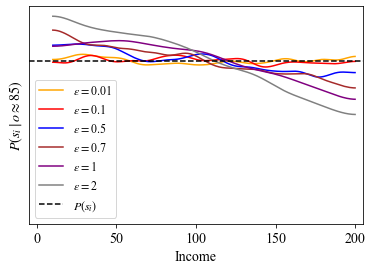

In [9]:
fig, ax = plt.subplots()
colors=['orange','red','blue','brown','purple','gray']
[az.plot_kde(traces[i].posterior['secret'][:,:,0].values.reshape(20000),
             ax=ax,plot_kwargs={'color': colors[i]},label='$\epsilon=$'+str(l)) for (i,l) in zip(range(0,6),x)]
plt.axhline(y=1/190,color='black',linestyle='--',label='$P(s_i)$')
plt.ylabel(r'$P(s_i \mid o \approx 85)$')
plt.xlabel("Income")
plt.xlim((-5,205))
plt.yticks(())
plt.legend(loc='best',prop={"size":12})
plt.show()

### Mutual Information

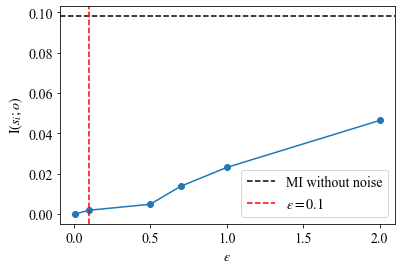

In [12]:
## NOTE: use traces without observation
x=[0.01,0.1,0.5,0.7,1,2]
traces=[trace_ϵ001,trace_ϵ01,trace_ϵ05,trace_ϵ07,trace_ϵ1,trace_ϵ2]
y=[mutual_info_regression(traces[i].posterior['secret'][:,:,0].values.reshape(20000).reshape(-1,1), 
                       traces[i].posterior['noisy_output'].values.reshape(20000), 
                       discrete_features=False,n_neighbors=40)[0] for i in range(0,6)]
plt.plot(x,y,marker='o')
plt.axhline(y=mutual_info_regression(trace_ϵ2.posterior['secret'][:,:,0].values.reshape(20000).reshape(-1,1), 
                       trace_ϵ2.posterior['output'].values.reshape(20000), 
                       discrete_features=False,n_neighbors=40)[0],color='black',linestyle='--',label='MI without noise')
plt.axvline(x=0.1,color='red',linestyle='--',label='$\epsilon=0.1$')
plt.xlabel('$\epsilon$')
plt.ylabel('$\mathrm{I}(s_i;o)$')
plt.legend(loc='best')
plt.show()

### KL-divergence (utility)

We have implemented our own KL-divergence estimator for Figaro/Scala, but for pymc3 traces we use the existing KL-divergence estimators from https://github.com/nhartland/KL-divergence-estimators

In [14]:
#### Estimators downloaded from https://github.com/nhartland/KL-divergence-estimators
""" KL-Divergence estimation through K-Nearest Neighbours
    This module provides four implementations of the K-NN divergence estimator of
        Qing Wang, Sanjeev R. Kulkarni, and Sergio Verdú.
        "Divergence estimation for multidimensional densities via
        k-nearest-neighbor distances." Information Theory, IEEE Transactions on
        55.5 (2009): 2392-2405.
    The implementations are through:
        numpy (naive_estimator)
        scipy (scipy_estimator)
        scikit-learn (skl_estimator)
    No guarantees are made w.r.t the efficiency of these implementations.
"""
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree


def knn_distance(point, sample, k):
    """ Euclidean distance from `point` to it's `k`-Nearest
    Neighbour in `sample` """
    norms = np.linalg.norm(sample-point, axis=1)
    return np.sort(norms)[k]


def verify_sample_shapes(s1, s2, k):
    # Expects [N, D]
    assert(len(s1.shape) == len(s2.shape) == 2)
    # Check dimensionality of sample is identical
    assert(s1.shape[1] == s2.shape[1])


def naive_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using brute-force (numpy) k-NN
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    D = np.log(m / (n - 1))
    d = float(s1.shape[1])

    for p1 in s1:
        nu = knn_distance(p1, s2, k-1)  # -1 because 'p1' is not in 's2'
        rho = knn_distance(p1, s1, k)
        D += (d/n)*np.log(nu/rho)
    return D


def scipy_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scipy's KDTree
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    nu_d,  nu_i   = KDTree(s2).query(s1, k)
    rho_d, rhio_i = KDTree(s1).query(s1, k+1)

    # KTree.query returns different shape in k==1 vs k > 1
    if k > 1:
        D += (d/n)*np.sum(np.log(nu_d[::, -1]/rho_d[::, -1]))
    else:
        D += (d/n)*np.sum(np.log(nu_d/rho_d[::, -1]))

    return D


def skl_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scikit-learn's NearestNeighbours
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    s1_neighbourhood = NearestNeighbors(k+1, 10).fit(s1)
    s2_neighbourhood = NearestNeighbors(k, 10).fit(s2)

    for p1 in s1:
        s1_distances, indices = s1_neighbourhood.kneighbors([p1], k+1)
        s2_distances, indices = s2_neighbourhood.kneighbors([p1], k)
        rho = s1_distances[0][-1]
        nu = s2_distances[0][-1]
        D += (d/n)*np.log(nu/rho)
    return D

def gaussian_divergence(mu1, mu2, sig1, sig2):
    """ Analytical result for KL-divergence of two Gaussians.
    D( N(mu1, sig1) | N(mu2,sig2) )
    Ref: http://allisons.org/ll/MML/KL/Normal/
    """

    mudiff  = pow(mu1-mu2, 2)
    sigdiff = sig1*sig1 - sig2*sig2
    lograt  = np.log(sig2/sig1)
    return lograt + (mudiff + sigdiff) / (2*sig2*sig2)

# List of all estimators
Estimators = [naive_estimator, scipy_estimator, skl_estimator]

In [15]:
## NOTE: use traces without observation
y=[scipy_estimator(trace.posterior['output'].values.reshape(20000).reshape(-1,1),
                   trace.posterior['noisy_output'].values.reshape(20000).reshape(-1,1),
                   k=10) for trace in traces]
plt.axvline(x=0.1,color='red',linestyle='--',label='$\epsilon=0.1$')
plt.plot(x,y,marker='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\mathrm{D}_{\mathrm{KL}}(\mathit{ro}\;||\;o)$')
plt.legend(loc='best')
plt.show()